# SVM支持向量机
### 此教程分为两个部分:

* 第一个部分旨在使用可视化的方式让同学们理解SVM的工作原理, SVM分割线, SVM的支持向量. 并且使用实例证明SVM的分割线只由支持向量唯一确定, 与线性回归/逻辑回归不一样, SVM对异常数据具有较强的鲁棒性.
* 第二个部分展示了如何使用SVM检测蘑菇🍄是否有毒. 对输入的蘑菇的特征, 使用PCA(主成分分析)将特征(一维向量)进行了降维处理, 然后将降维后的向量作为支持向量机的输入. PCA降维的目的可以看作是特征提取, 将特征里面真正对分类有决定性影响的数据提取出来.

# 一. 理解SVM


In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 创建模拟数据集

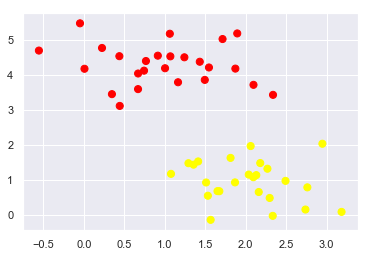

In [29]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

## 可行的分割线


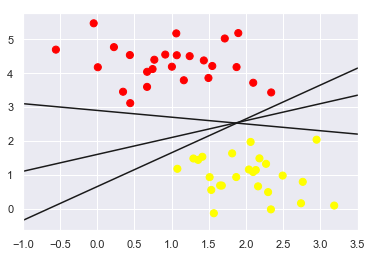

In [30]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

## SVM: 假想每一条分割线是有宽度的
在SVM的框架下, 认为最宽的线为最优的分割线

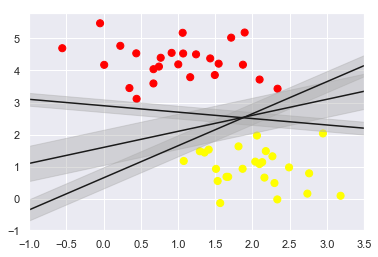

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

## 训练SVM

使用线性SVM和比较大的 ``C`` 

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### 创建一个显示SVM分割线的函数

In [12]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## 显示分割线

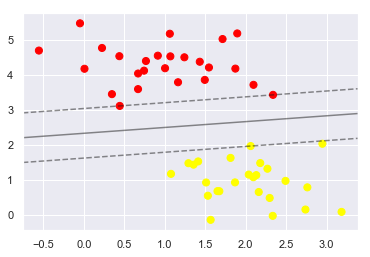

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

## 显示支持向量

In [14]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

## 演示非支持向量的数据, 对分割线没有影响

只有支持向量会影响分割线, 如果我们添加一些非支持向量的数据, 对分割线没有影响

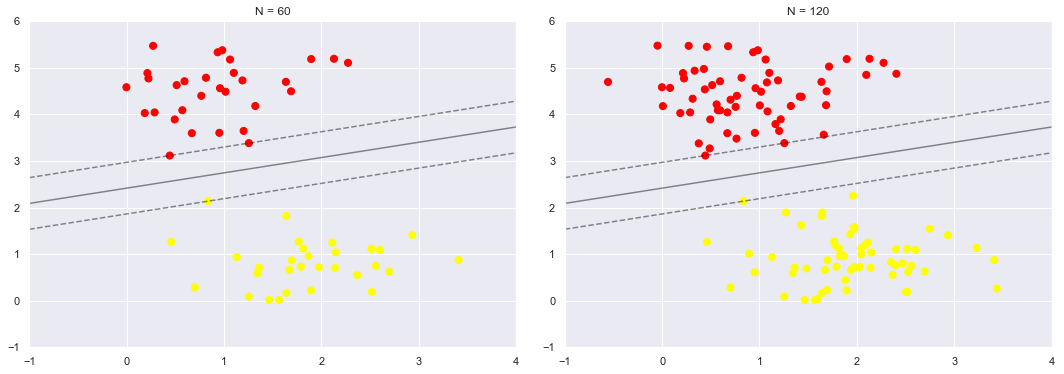

In [15]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [50, 200]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

# 二. 使用SVM检测蘑菇🍄是否有毒
使用的数据集: https://archive.ics.uci.edu/ml/datasets/mushroom
 
数据集中每一条数据包含如下特征, 特征包括对蘑菇形状, 质地, 色彩等特征的描述, 我们需要以此判断🍄是否有毒(p)或者可以吃(e). 为两个类别的分类问题.

1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s 
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s 
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y 
4. bruises?: bruises=t,no=f 
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s 
6. gill-attachment: attached=a,descending=d,free=f,notched=n 
7. gill-spacing: close=c,crowded=w,distant=d 
8. gill-size: broad=b,narrow=n 
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y 
10. stalk-shape: enlarging=e,tapering=t 
11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=? 
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s 
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s 
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
16. veil-type: partial=p,universal=u 
17. veil-color: brown=n,orange=o,white=w,yellow=y 
18. ring-number: none=n,one=o,two=t 
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z 
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y 
21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y 
22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [16]:
import pandas as pd
import numpy as np

# 导入数据
mush_df = pd.read_csv('mushrooms.csv')

# 将值从字母转换为
mush_df_encoded = pd.get_dummies(mush_df)

mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [17]:
mush_df_encoded.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
# 将特征和类别标签分布赋值给 X 和 y
X_mush = mush_df_encoded.iloc[:,2:]
y_mush = mush_df_encoded.iloc[:,1]

## 训练SVM

### 建立pipeline

In [22]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=15, whiten=True, random_state=42)
svc = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(pca, svc)

### 将数据分为训练和测试数据

In [23]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_mush, y_mush,
                                                random_state=41)

### 调参:通过交叉验证寻找最佳的 C (控制松弛度, C 越大, 越不容许松弛)

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 8.22 s, sys: 161 ms, total: 8.38 s
Wall time: 8.04 s
{'svc__C': 10}


### 使用训练好的SVM做预测

In [25]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

### 生成性能报告

In [26]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=['e','p']))

              precision    recall  f1-score   support

           e       0.97      0.96      0.96      1047
           p       0.96      0.97      0.96       984

   micro avg       0.96      0.96      0.96      2031
   macro avg       0.96      0.96      0.96      2031
weighted avg       0.96      0.96      0.96      2031



# 使用Kernel SVM

In [27]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(Xtrain, ytrain)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, clf.predict(Xtest)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.975 (+/-0.007) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.913 (+/-0.009) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.975 (+/-0.007) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.002) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.005) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
1.000 (+/-0.002) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 10, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 100, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed